In [58]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("Microsoft/microsoft-security-incident-prediction")

# print("Path to dataset files:", path)

# https://www.kaggle.com/datasets/Microsoft/microsoft-security-incident-prediction
# https://arxiv.org/abs/2407.09017
# https://www.microsoft.com/en-us/research/publication/microsoft-security-incident-prediction/

# Microsoft Incident/Alert schema
# https://learn.microsoft.com/en-us/defender-xdr/advanced-hunting-alertevidence-table

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, f1_score, confusion_matrix, classification_report, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from imblearn.metrics import specificity_score

from sklearn.ensemble import RandomForestClassifier


from plot_helpers import render_plot

pd.set_option('display.max_columns', None)

In [ ]:
dtype_spec = {                      # added to avoid a data load warning about objectives types for these features
    'ActionGrouped': 'object',
    'ActionGranular': 'object'
}

df_train = pd.read_csv('DATA/GUIDE_Train.csv', dtype=dtype_spec)
df_test = pd.read_csv('DATA/GUIDE_Test.csv', dtype=dtype_spec)

# Use for local testing with the larger data set which has 13M records. Unable to load this data set into GitHub.
# df_train = pd.read_csv('ORIGINAL-DATA/GUIDE_Train.csv')
# df_test = pd.read_csv('ORIGINAL-DATA/GUIDE_Test.csv')

In [61]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  100000 non-null  int64  
 1   OrgId               100000 non-null  int64  
 2   IncidentId          100000 non-null  int64  
 3   AlertId             100000 non-null  int64  
 4   Timestamp           100000 non-null  object 
 5   DetectorId          100000 non-null  int64  
 6   AlertTitle          100000 non-null  int64  
 7   Category            100000 non-null  object 
 8   MitreTechniques     44576 non-null   object 
 9   IncidentGrade       100000 non-null  object 
 10  ActionGrouped       41 non-null      object 
 11  ActionGranular      41 non-null      object 
 12  EntityType          100000 non-null  object 
 13  EvidenceRole        100000 non-null  object 
 14  DeviceId            100000 non-null  int64  
 15  Sha256              100000 non-null

In [62]:
df_train.shape, df_test.shape

((100000, 45), (100000, 46))

In [63]:
# find the column that is different between the two data sets
set(df_train.columns).symmetric_difference(set(df_test.columns))

{'Usage'}

In [64]:
# explore the value within the Usage column in the test data set
df_test.Usage.value_counts()


Usage
Public     70405
Private    29595
Name: count, dtype: int64

In [65]:
# The usage columns is not present in the training data. And it appears to be a column that indicates how the data should be used. 
# We will drop this column from the test data set
df_test.drop(columns=['Usage'], inplace=True)

In [66]:
# check for missing values in target variable in both data sets
df_train.IncidentGrade.isna().sum(), df_test.IncidentGrade.isna().sum()

(525, 0)

In [67]:
# drop the rows with missing values in the target variable
df_train.dropna(subset=['IncidentGrade'], inplace=True), df_test.dropna(subset=['IncidentGrade'], inplace=True)

(None, None)

In [131]:
#### Columns not needed for this analyis
# This data set has labels for two different needs: initial triage of incidents/alerts, and proposed remediation actions. 
# This objective of my analysis is only to predict a triage ground truth - true positive, benign positive and false positive. 
# As such i will ignore the columsn related to proposed remedation actions ( Last Verdict, ActionGrouped, Action Granualar, LastVerdict, SuspicionLevel)

cat_columns = ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict',
               'ResourceType', 'Roles', 'AntispamDirection', 'ThreatFamily']

numerical_columns = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
                     'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey',
                     'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
                     'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 
                     'OSVersion', 'CountryCode', 'State', 'City']

# create a list to drop additional columns that may not be needed after EDA
drop_columns = []



In [69]:
# convert timestamp to datetime
df_train['Timestamp'] = pd.to_datetime(df_train['Timestamp'])
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])

# convert MitreTechniques to extract first technique
df_train['FirstMitreTechnique'] = df_train['MitreTechniques'].str.split(';').str[0]
df_test['FirstMitreTechnique'] = df_test['MitreTechniques'].str.split(';').str[0]

df_train['FirstMitreTechnique'] = df_train['FirstMitreTechnique'].str.split('.').str[0]
df_test['FirstMitreTechnique'] = df_test['FirstMitreTechnique'].str.split('.').str[0]

# add MitreColumns to be dropped later
drop_columns.append('MitreTechniques')

In [70]:
# Find null values in the dataset
null_values = df_train.isnull().sum()
print(null_values.sort_values(ascending=False))


ActionGrouped          99412
ActionGranular         99412
ResourceType           99385
ThreatFamily           98675
EmailClusterId         98459
AntispamDirection      97695
Roles                  97209
SuspicionLevel         84423
LastVerdict            76128
FirstMitreTechnique    57092
MitreTechniques        57092
OSVersion                  0
RegistryKey                0
CountryCode                0
State                      0
ResourceIdName             0
FolderPath                 0
FileName                   0
City                       0
OAuthApplicationId         0
ApplicationName            0
ApplicationId              0
RegistryValueData          0
RegistryValueName          0
OSFamily                   0
Id                         0
OrgId                      0
DeviceName                 0
IncidentId                 0
AlertId                    0
Timestamp                  0
DetectorId                 0
AlertTitle                 0
Category                   0
IncidentGrade 

In [71]:
# After EDA removing columns with more than 80% missing values
drop_columns.extend(['ResourceType', 'ActionGrouped', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Roles', 'AntispamDirection'])
drop_columns

['MitreTechniques',
 'ResourceType',
 'ActionGrouped',
 'ActionGranular',
 'ThreatFamily',
 'EmailClusterId',
 'Roles',
 'AntispamDirection']

In [72]:
df_train.AlertId.nunique(), df_train.shape

(81677, (99475, 46))

<Axes: xlabel='IncidentGrade', ylabel='count'>

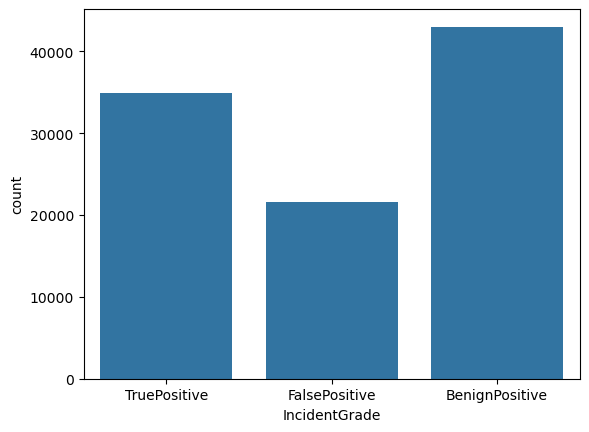

In [73]:
# Explore IncidentGrade
sns.countplot(x='IncidentGrade', data=df_train)

#### Fairly balanced classes

<Axes: xlabel='IncidentGrade', ylabel='count'>

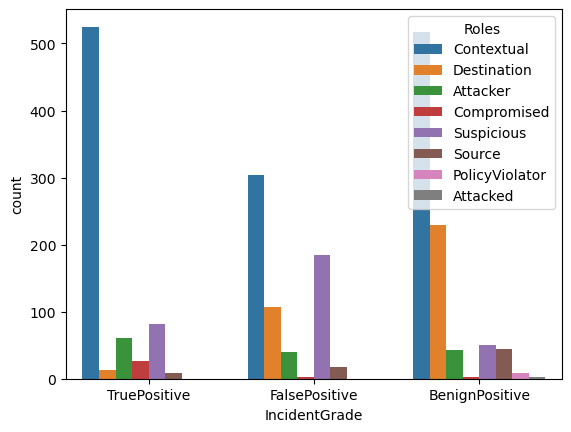

In [74]:
# Explore Roles with IncidentGrade
sns.countplot(x='IncidentGrade', hue='Roles', data=df_train)


In [132]:
# Find all incidents with duplicate AlertIds
duplicate_alerts = df_train[df_train.duplicated('AlertId', keep=False)]

# Show a few sample incidents that are marked true positive
duplicate_alerts[duplicate_alerts['IncidentGrade'] == 'TruePositive'].head(5)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,SuspicionLevel,CountryCode,State,City,FirstMitreTechnique,IncidentGradeNum
27,489626273557,0,211,160158,2024-06-11 08:26:58+00:00,0,0,InitialAccess,TruePositive,CloudLogonRequest,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,NaN,242,1445,10630,T1078,1
51,1486058687146,8,5447,12744,2024-06-03 04:47:13+00:00,1,1,InitialAccess,TruePositive,User,Impacted,98799,138268,360606,160396,10365,8793,9959,10734,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,NaN,242,1445,10630,T1566,1
84,755914248188,24,71757,48212,2024-06-07 00:52:03+00:00,1,1,InitialAccess,TruePositive,MailCluster,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,NaN,242,1445,10630,T1566,1
100,352187320755,28,9445,27326,2024-06-14 14:28:47+00:00,1,1,InitialAccess,TruePositive,Mailbox,Impacted,98799,138268,360606,160396,87766,102627,100975,64996,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,NaN,242,1445,10630,T1566,1
114,670014901898,148,20,32531,2024-06-04 08:45:48+00:00,1264,13900,Exfiltration,TruePositive,File,Impacted,98799,36136,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,60366,31161,3586,5,66,NaN,242,1445,10630,NaN,1


In [76]:
# Unique values in registry key
df_train['EntityType'].value_counts()

EntityType
Ip                       22868
User                     20007
MailMessage              12300
Url                       7295
Machine                   7208
File                      7128
CloudLogonRequest         6658
Mailbox                   5065
Process                   3576
MailCluster               2419
CloudApplication          2295
CloudLogonSession         2229
RegistryValue              115
AzureResource              105
RegistryKey                 89
GenericEntity               36
Malware                     30
OAuthApplication            25
SecurityGroup               16
Blob                         4
BlobContainer                2
MailboxConfiguration         2
ActiveDirectoryDomain        1
IoTDevice                    1
AmazonResource               1
Name: count, dtype: int64

In [77]:
# for the ratio of Category, and show top 10 categories of alerts
df_train['Category'].value_counts(normalize=True).sort_values(ascending=False).head(10)*100

Category
InitialAccess         45.436542
Exfiltration          16.367932
SuspiciousActivity    10.492083
CommandAndControl      8.725811
Impact                 7.991958
CredentialAccess       3.024881
Execution              2.851973
Malware                1.520985
Discovery              1.388289
Persistence            0.709726
Name: proportion, dtype: float64

#### Top categories for logging Incidents and Alerts are InitialAccess, Exfiltration, SuspiciousActivity, CommandA8dControl

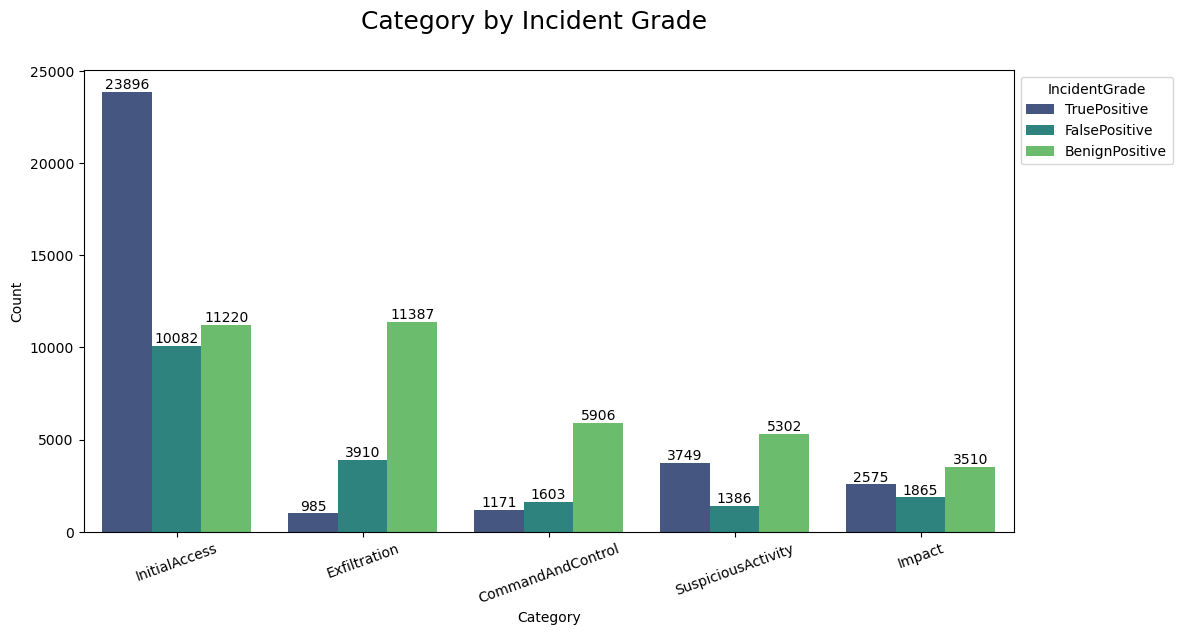

In [78]:
# plot top 5 categories with incident grade

plt.figure(figsize=(12, 6))
top_10_categories = df_train['Category'].value_counts().head(5).index
ax = sns.countplot(data=df_train[df_train['Category'].isin(top_10_categories)], x='Category', hue='IncidentGrade', palette='viridis')

render_plot(ax, heading='Category by Incident Grade', xlabel='Category', ylabel='Count')


#### Exfiltration attemps appear to be last harmful compared to alerts marked as Initial Access, Suspicious or Impact

#### Last Verdict
https://learn.microsoft.com/en-us/defender-xdr/m365d-remediation-actions

In [79]:
# explore the values within LastVerdict
print(df_train['LastVerdict'].value_counts())


LastVerdict
Suspicious        14648
Malicious          4508
NoThreatsFound     4191
Name: count, dtype: int64


In [80]:

# remove LastVerdict values that begin with 'Domain'
df_last_verdict = df_train[~df_train['LastVerdict'].str.startswith('Domain', na=False)]

In [81]:
# Summarize LastVerdict
print('Number of missing values in Last Verdict are: ', df_last_verdict['LastVerdict'].isna().sum()  )

Number of missing values in Last Verdict are:  76128


In [82]:
# Remove last verdict column, since this is used post the initial triage
drop_columns.append('LastVerdict')

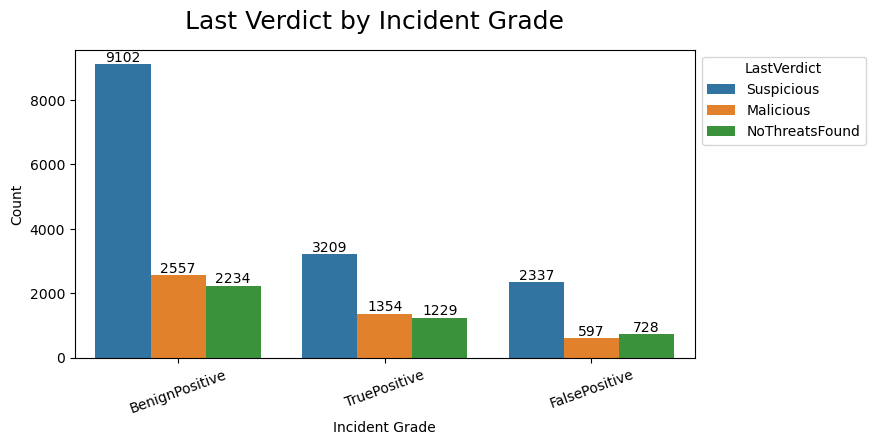

In [83]:
# plot LastVerdict by Incident Grade
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_last_verdict, x='IncidentGrade', hue='LastVerdict', order=df_last_verdict['IncidentGrade'].value_counts().index)

render_plot(ax, heading='Last Verdict by Incident Grade', xlabel='Incident Grade', ylabel='Count')


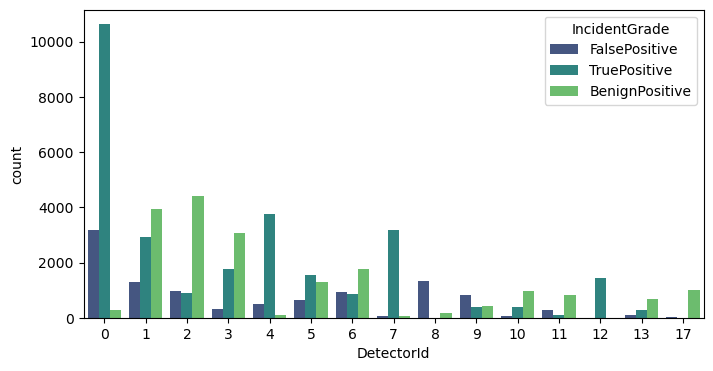

In [84]:
# plot top 10 Detectors by Incident Grade
plt.figure(figsize=(8, 4))
top_10_detectors = df_train['DetectorId'].value_counts().head(15).index
ax = sns.countplot(data=df_train[df_train['DetectorId'].isin(top_10_detectors)], x='DetectorId', hue='IncidentGrade', palette='viridis')

In [85]:
# "DetectorId 0" typically refers to a generic or default detection mechanism, meaning it signifies an alert triggered by a broad security
# rule that isn't specifically tied to a particular security feature or detection method within the XDR platform; it usually indicates a 
# high-level threat that needs further investigation to pinpoint the exact source of the suspicious activity

# check the entity type for DetectorId = 0
df_train[df_train['DetectorId'] == 0]['EntityType'].value_counts()

EntityType
User                 4057
CloudLogonRequest    4000
Ip                   3983
CloudLogonSession    2044
Name: count, dtype: int64

### EntityTypes
https://learn.microsoft.com/en-us/azure/sentinel/entities-reference

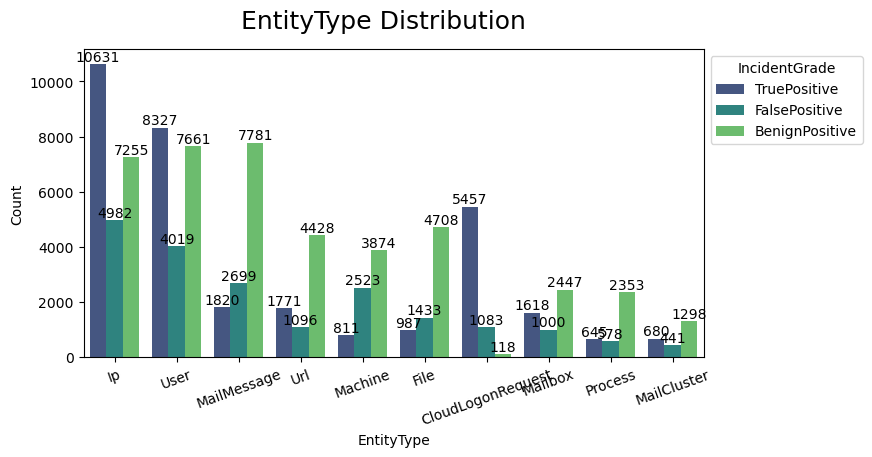

In [86]:
# check the distribution of EntityTypes
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_train, x='EntityType', hue='IncidentGrade', order=df_train['EntityType'].value_counts().head(10).index, palette='viridis')
render_plot(ax, heading='EntityType Distribution', xlabel='EntityType', ylabel='Count')


In [87]:
# Explore IncidentId 5447

# df_train[df_train['IncidentId'] == 5447]

In [88]:
#"evidencerole" refers to the specific part a particular piece of evidence plays within a security alert, indicating whether 
# it is the primary target of the attack, a related component, or simply provides supporting context for the incident; 
# essentially, it describes how the evidence is involved in the overall threat scenario

df_train.groupby(['IncidentGrade', 'EvidenceRole']).size().sort_values(ascending=False)  

IncidentGrade   EvidenceRole
TruePositive    Related         22847
BenignPositive  Impacted        22566
                Related         20458
TruePositive    Impacted        12040
FalsePositive   Related         11285
                Impacted        10279
dtype: int64

#### MitreTechniques
https://attack.mitre.org/

In [89]:
df_train.groupby(['FirstMitreTechnique', 'IncidentGrade']).size().sort_values(ascending=False)
# df_sorted = df_grouped.sort_values(by='size', ascending=False)
# df_sorted

FirstMitreTechnique  IncidentGrade 
T1078                TruePositive      10750
T1566                BenignPositive     8731
                     TruePositive       4973
T1078                FalsePositive      3403
T1566                FalsePositive      3252
                                       ...  
T1119                FalsePositive         1
T1053                TruePositive          1
T1052                FalsePositive         1
T1129                BenignPositive        1
T1220                BenignPositive        1
Length: 250, dtype: int64

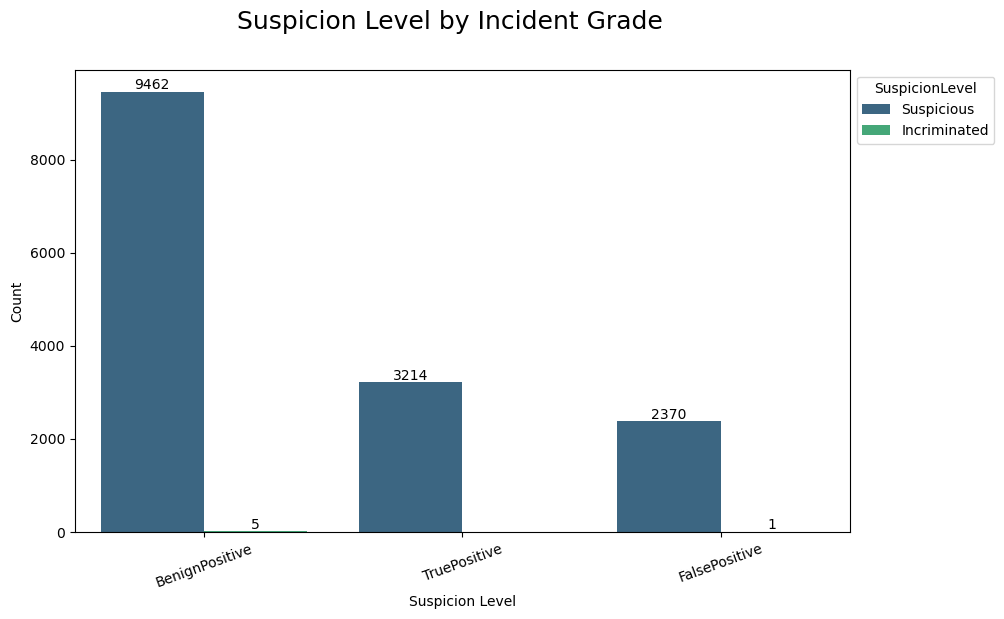

In [90]:
# "suspicion level" refers to the degree of confidence that a detected activity is potentially malicious, 
# often indicated by a "suspicious" verdict within an alert, meaning the system believes there is a high likelihood of a threat 
# but further investigation is needed before taking definitive action; this level can be considered as a 
# middle ground between "clean" (not malicious) and "malicious" (confirmed threat)

# Explore SuspicionLevel feature along with IncidentGrade

# Plot SuspicionLevel with IncidentGrade
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_train, x='IncidentGrade', hue='SuspicionLevel', palette='viridis', order=df_train['IncidentGrade'].value_counts().index)
render_plot(ax, heading='Suspicion Level by Incident Grade', xlabel='Suspicion Level', ylabel='Count')



### EDA Numerical Data

In [91]:
# Add a numerical feature for IncidentGrade
df_train['IncidentGradeNum'] = df_train['IncidentGrade'].map({'TruePositive': 1, 'FalsePositive': -1, 'BenignPositive': 0})

#drop_columns.append('IncidentGrade')

In [92]:
df_train['IncidentGradeNum'].value_counts()

IncidentGradeNum
 0    43024
 1    34887
-1    21564
Name: count, dtype: int64

In [93]:
# Analyze Geographical Features

num_features_geo = ['CountryCode', 'State', 'City', 'IncidentGradeNum']

# Top 10 countries by Incident Grade
# top_10_countries = df_train['CountryCode'].value_counts().head(10)


# Top 10 countries/state/city by Incident Grade
top_10_country_states = df_train.groupby(['CountryCode', 'State', 'City']).size().reset_index(name='size').sort_values(by='size', ascending=False).head(10)
top_10_country_states

,CountryCode,State,City,size
942,242,1445,10630,91559
321,1,0,0,1138
465,5,1445,10630,313
0,0,1,1,236
334,2,2,2,220
512,10,7,4,140
495,7,8,6,133
320,0,1445,10630,131
1,0,1,5,130
505,8,10,7,110


This data set represents region 2 in the XDR data that was released by the provider. It is not suprising to see code 242 as the main contributor of all the indicents in this data set

#### Alerts/Incidents by City/state/country
Most alerts/incidents appear to be generated from the same location. 

<Axes: >

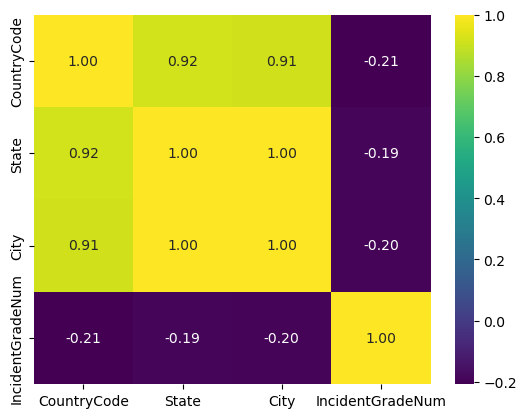

In [94]:
sns.heatmap(df_train[num_features_geo].corr(), annot=True, cmap='viridis', fmt=".2f")

<Axes: >

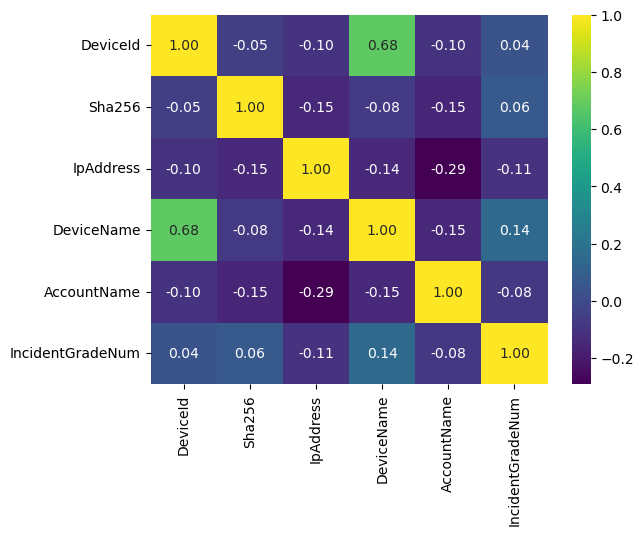

In [95]:
num_features_device = ['DeviceId', 'Sha256', 'IpAddress', 'DeviceName', 'AccountName', 'IncidentGradeNum']

sns.heatmap(df_train[num_features_device].corr(), annot=True, cmap='viridis', fmt=".2f")

<Axes: >

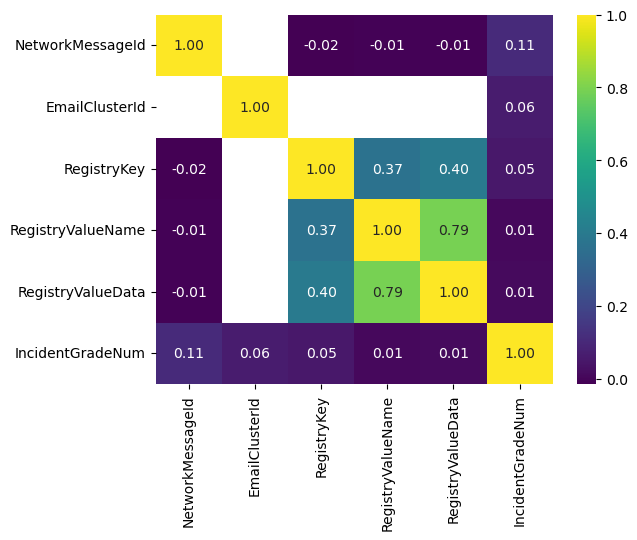

In [96]:
num_features_infr = ['NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'IncidentGradeNum']
sns.heatmap(df_train[num_features_infr].corr(), annot=True, cmap='viridis', fmt=".2f")

#### Weak correlation between IncidentGrade and Numerical Features

### Data Clean Up   

In [97]:
# Drop Columns marked in the EDA section

print('Columns to be dropped: ', drop_columns)  

df_train.drop(columns=drop_columns, axis=1, inplace=True)
df_test.drop(columns=drop_columns, axis=1, inplace=True)

Columns to be dropped:  ['MitreTechniques', 'ResourceType', 'ActionGrouped', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Roles', 'AntispamDirection', 'LastVerdict']


In [98]:
cat_columns = [col for col in cat_columns if col not in drop_columns]

numerical_columns = [col for col in numerical_columns if col not in drop_columns]

print(cat_columns, numerical_columns)

['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel'] ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City']


### Train/Test Split

In [99]:
# categorical columns
ohe = OneHotEncoder(handle_unknown='ignore', )
ohe.fit(df_train[cat_columns])

X_train_ohe = ohe.transform(df_train[cat_columns])
X_test_ohe = ohe.transform(df_test[cat_columns])

X_train_ohe_df = pd.DataFrame(X_train_ohe.toarray(), columns=ohe.get_feature_names_out())
X_test_ohe_df = pd.DataFrame(X_test_ohe.toarray(), columns=ohe.get_feature_names_out())

# numerical columns - not scaling them, since these values are not continuous and rather represent various entities, devices etc
X_train_data_numerical = df_train[numerical_columns].fillna(-1)
X_test_data_numerical = df_test[numerical_columns].fillna(-1)

# concatenate data frame
X_train = pd.concat([X_train_ohe_df, X_train_data_numerical.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_ohe_df, X_test_data_numerical.reset_index(drop=True)], axis=1)

In [100]:
X_train.sample(3)

,Category_Collection,Category_CommandAndControl,Category_CredentialAccess,Category_CredentialStealing,Category_DefenseEvasion,Category_Discovery,Category_Execution,Category_Exfiltration,Category_Exploit,Category_Impact,Category_InitialAccess,Category_LateralMovement,Category_Malware,Category_Persistence,Category_PrivilegeEscalation,Category_Ransomware,Category_SuspiciousActivity,Category_UnwantedSoftware,EntityType_ActiveDirectoryDomain,EntityType_AmazonResource,EntityType_AzureResource,EntityType_Blob,EntityType_BlobContainer,EntityType_CloudApplication,EntityType_CloudLogonRequest,EntityType_CloudLogonSession,EntityType_File,EntityType_GenericEntity,EntityType_IoTDevice,EntityType_Ip,EntityType_Machine,EntityType_MailCluster,EntityType_MailMessage,EntityType_Mailbox,EntityType_MailboxConfiguration,EntityType_Malware,EntityType_OAuthApplication,EntityType_Process,EntityType_RegistryKey,EntityType_RegistryValue,EntityType_SecurityGroup,EntityType_Url,EntityType_User,EvidenceRole_Impacted,EvidenceRole_Related,SuspicionLevel_Incriminated,SuspicionLevel_Suspicious,SuspicionLevel_nan,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
44061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,98799,138268,496,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
96027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,98799,1,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,1,1,3586,5,66,242,1445,10630
75024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,98799,138268,2409,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,20,20,22


In [101]:
y_train = df_train['IncidentGrade']
y_test = df_test['IncidentGrade']

### Basic Classifiers

In [102]:
# helper function to run and evaluate models, pipelines and gridsearchcv

def run_and_eval_model(model, model_name, X_train, X_test, y_train, y_test):
    
    print(f"Evaluating {model_name}")
    
    start_time = time.time()

    # fit the selected model 
    model.fit(X_train, y_train.values.ravel())
    
    fit_time = round(time.time() - start_time, 2)
    
    start_time = time.time()

    train_score = cross_val_score(model, X_train, y_train.values.ravel(), cv=5, scoring='accuracy').mean()
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(classification_report(y_test, y_pred))
    
    eval_time = round(time.time() - start_time, 2)
    
    print(f"{model_name} with train accuracy score {train_score:.3f}, took {time.time()-start_time:.3f} seconds")
    
    return {'model': model_name, 
            'train accuracy': train_score, 
            'test accuracy': test_accuracy,
            'precision': precision, 
            'recall': recall,
            'f1': f1,
            'fit time': fit_time,
            'eval time': eval_time}
    
def draw_roc_curves(X_test, y_test, model):
    
    # Create ROC curves for each of the classes

    # Get the predicted probabilities
    y_score = model.predict_proba(X_test)

    # Binarize the output labels for ROC curve
    y_test_bin = pd.get_dummies(y_test)

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(y_test_bin.columns):
        fpr, tpr, _ = roc_curve(y_test_bin[class_name], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for class {class_name}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Evaluating Decision Trees
                precision    recall  f1-score   support

BenignPositive       0.70      0.73      0.71     42352
 FalsePositive       0.55      0.48      0.51     21612
  TruePositive       0.71      0.73      0.72     36036

      accuracy                           0.68    100000
     macro avg       0.66      0.65      0.65    100000
  weighted avg       0.67      0.68      0.67    100000

Decision Trees with train accuracy score 0.676, took 5.604 seconds


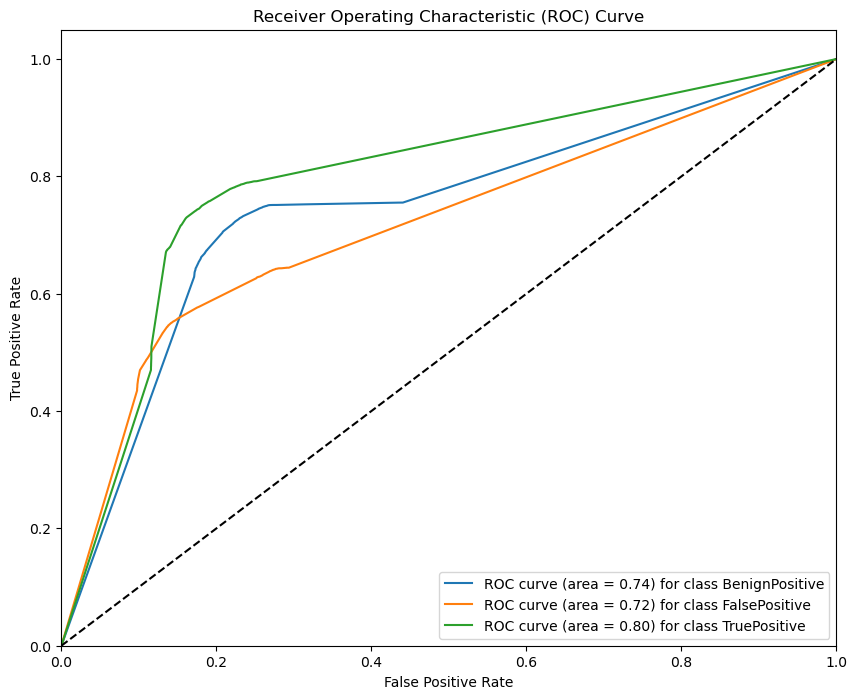

Evaluating Random Forest
                precision    recall  f1-score   support

BenignPositive       0.70      0.78      0.74     42352
 FalsePositive       0.61      0.47      0.53     21612
  TruePositive       0.73      0.74      0.74     36036

      accuracy                           0.70    100000
     macro avg       0.68      0.66      0.67    100000
  weighted avg       0.69      0.70      0.69    100000

Random Forest with train accuracy score 0.699, took 48.661 seconds


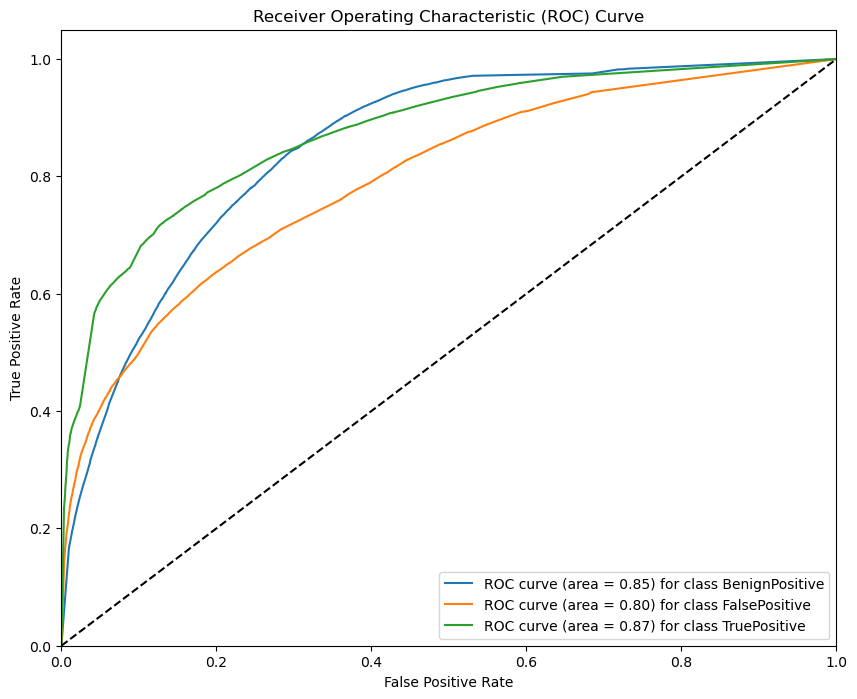

,model,train accuracy,test accuracy,precision,recall,f1,fit time,eval time
0,Decision Trees,0.676441,0.67697,0.655290,0.647540,0.650374,0.58,5.60
1,Random Forest,0.698769,0.69783,0.682477,0.661977,0.668036,10.78,48.66


In [103]:
# Define the pipelines for all classification models with default hyperparameters

pipelines = {
    'Decision Trees': Pipeline([('classifier', DecisionTreeClassifier())]),
    #'SVM': Pipeline([('classifier', SVC(decision_function_shape='ovr'))]),
    'Random Forest': Pipeline([('classifier', RandomForestClassifier())]),
}

models_evaluated = pd.DataFrame()

for model_name, pipeline in pipelines.items():
    dict = run_and_eval_model(pipeline, model_name, X_train, X_test, y_train, y_test)
    models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
    draw_roc_curves(X_test, y_test, pipeline)
    
models_evaluated


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)


In [105]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

Accuracy: 0.67711
Macro-Precision: 0.6553331254573413
Macro-Recall: 0.6476988283051747
Macro-F1 Score: 0.6504821182112026


In [106]:
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

BenignPositive       0.70      0.73      0.71     42352
 FalsePositive       0.55      0.48      0.51     21612
  TruePositive       0.71      0.73      0.72     36036

      accuracy                           0.68    100000
     macro avg       0.66      0.65      0.65    100000
  weighted avg       0.67      0.68      0.67    100000



In [134]:
# export the tree
feature_names = dt.feature_names_in_

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]

# feature important
features_importance = pd.DataFrame({'feature': clean_feature_names, 'importance': dt.feature_importances_})
    
# sort the features by importance
features_importance.sort_values(by='importance', ascending=False).head(10)

depth = export_text(dt, feature_names=clean_feature_names)
export_text(dt, feature_names=clean_feature_names, show_weights=True)

print(depth[0:1000])

|--- Category_InitialAccess <= 0.50
|   |--- Category_Exfiltration <= 0.50
|   |   |--- Category_CommandAndControl <= 0.50
|   |   |   |--- FolderPath <= 15.50
|   |   |   |   |--- FolderPath <= 3.50
|   |   |   |   |   |--- FileName <= 6.00
|   |   |   |   |   |   |--- FileName <= 0.50
|   |   |   |   |   |   |   |--- Category_SuspiciousActivity <= 0.50
|   |   |   |   |   |   |   |   |--- Sha256 <= 19375.00
|   |   |   |   |   |   |   |   |   |--- Category_Malware <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Category_CredentialAccess <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: BenignPositive
|   |   |   |   |   |   |   |   |   |   |--- Category_CredentialAccess >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- Category_Malware >  0.50
|   |   |   |   |   |   |   |   |   |   |--- Sha256 <= 35.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |  

In [108]:
features_importance.sort_values(by='importance', ascending=False).head(10)

,feature,importance
50,IpAddress,0.173335
53,AccountUpn,0.115097
10,Category_InitialAccess,0.100160
52,AccountSid,0.099859
51,Url,0.058846
57,NetworkMessageId,0.058321
55,AccountName,0.047126
56,DeviceName,0.045174
54,AccountObjectId,0.044903
64,FileName,0.038423


In [ ]:
tree_depth = dt.tree_.max_depth  

print("Depth of the fitted decision tree:", tree_depth) 

Depth of the fitted decision tree: 83


That is a very deep tree !!

In [127]:
# setup a GridSearchCV for the Decision Tree model

params = {'dt__min_impurity_decrease': [0.001, 0.01, 0.1],
          'dt__max_depth': [5,10,20],
          'dt__min_samples_split': [0.1, 0.05]}

dt_pipe = Pipeline([('dt', DecisionTreeClassifier(random_state = 42))])

dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=params, n_jobs=10, verbose=2)

dt_grid

GridSearchCV(estimator=Pipeline(steps=[('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=10,
             param_grid={'dt__max_depth': [5, 10, 20],
                         'dt__min_impurity_decrease': [0.001, 0.01, 0.1],
                         'dt__min_samples_split': [0.1, 0.05]},
             verbose=2)

In [128]:
dt_grid.fit(X_train, y_train)

y_pred = dt_grid.predict(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END dt__max_depth=5, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.5s
[CV] END dt__max_depth=5, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.5s
[CV] END dt__max_depth=5, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.4s
[CV] END dt__max_depth=5, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.5s
[CV] END dt__max_depth=5, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.1; total time=   0.6s
[CV] END dt__max_depth=5, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total time=   0.5s
[CV] END dt__max_depth=5, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total time=   0.6s
[CV] END dt__max_depth=5, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total time=   0.5s
[CV] END dt__max_depth=5, dt__min_impurity_decrease=0.001, dt__min_samples_split=0.05; total tim

In [129]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

Accuracy: 0.6406
Macro-Precision: 0.6990292413636943
Macro-Recall: 0.5573927375143045
Macro-F1 Score: 0.545158473223521


In [130]:
dt_grid.best_params_

{'dt__max_depth': 20,
 'dt__min_impurity_decrease': 0.001,
 'dt__min_samples_split': 0.05}